In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# load Dataframe
df = pd.read_csv('Salary_Data.csv')
df

,YearsExperience,Age,Salary
0,1.1,21.0,39343
1,1.3,21.5,46205
2,1.5,21.7,37731
3,2.0,22.0,43525
4,2.2,22.2,39891
5,2.9,23.0,56642
6,3.0,23.0,60150
7,3.2,23.3,54445
8,3.2,23.3,64445
9,3.7,23.6,57189


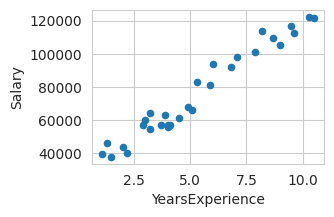

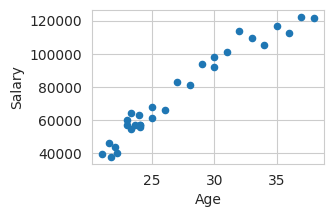

In [3]:
for column in df.columns:
    if column != "Salary":
        df.plot.scatter(x=column, y="Salary", figsize=(3, 2))

We can observe that no outliers are presenten. Therefore, is right to apply StandardScaler instead of RobustScaler

In [4]:
# Spliting features and target
y = df[['Salary']]      # Dataframe type
X = df.drop(y, axis=1)  # Dataframe type

# Spliting training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor  # supervised algorithm
from sklearn.decomposition import PCA  # unsupervised algorithm

pipe = make_pipeline(StandardScaler(),
                     PCA(),  # also works for regression tasks, unlike to LDA that only works for classification
                     KNeighborsRegressor(n_jobs=-1),
                     )

In [6]:
k_values = [1, 2, 3, 4]
n_components = [1, 2]
weights = ['uniform', 'distance']

"""
weights=uniform: no weight asigned to each neighbor
weights=distance: distance-based weight asigned to each neighbor
"""

param_grid = {'pca__n_components': n_components,
              'kneighborsregressor__n_neighbors': k_values,
              'kneighborsregressor__weights': weights}

# In the previous grid, two configurations will be evaluated.

In [7]:
from sklearn.model_selection import GridSearchCV

# create grid to obtain the best hyperparams
search = GridSearchCV(estimator=pipe,
                      param_grid=param_grid,
                      scoring='r2',  # Coefficient of determination.   r2 := 1 - (SSres/SStot).  range(r2)=[0, 1]
                      cv=5,
                      refit=True,
                      n_jobs=-1)

search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'kneighborsregressor__n_neighbors': [1, 2, 3, 4],
                         'kneighborsregressor__weights': ['uniform',
                                                          'distance'],
                         'pca__n_components': [1, 2]},
             scoring='r2')

In [8]:
best_params = search.best_params_
best_params

{'kneighborsregressor__n_neighbors': 3,
 'kneighborsregressor__weights': 'distance',
 'pca__n_components': 2}

In [9]:
# picking the best model
best_model = search.best_estimator_

In [10]:
# mean value (for the n_components*k_values = 8 configurations) for the mean r2 (mean obtained for the cv=5 folds)
r2_mean = search.cv_results_['mean_test_score'].mean()
r2_mean

0.9213440081533153

In [11]:
# best mean (per cv folds, not for GRID configuration. for the Best configuration) r2 value
search.best_score_

0.9499245071634486

In [12]:
# params of the pipeline which can be modified to re-fit
#pipe.get_params().keys()

In [13]:
#estimator = pipe.set_params(**best_params)

In [14]:
y_pred = best_model.predict(X_test)

In [15]:
y = y_test.copy()
y['Salary_pred'] = y_pred
y['rel_error'] = abs(y.Salary - y.Salary_pred)*100/y.Salary  # in percentage
y

,Salary,Salary_pred,rel_error
27,112635,116171.339053,3.139645
15,67938,61909.218638,8.873946
23,113812,105137.865048,7.621459
17,83088,76912.707812,7.432231
8,64445,54445.000000,15.517108
9,57189,59232.397409,3.573060


In [16]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)  # mean_squared_error (MSE)
rmse = np.sqrt(mse)                       # root mean_squared_error (RMSE)

print(f'MES:  {mse}')
print(f'RMSE: {rmse}')

MES:  44400370.39314223
RMSE: 6663.360292910945


In [17]:
y.rel_error.mean()

7.692908131494601

In [18]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(best_model, X_train, y_train, cv=kf, scoring='r2')
mse_scores.mean()
# This is comparable with search.best_score_=0.95

0.9683416058925085

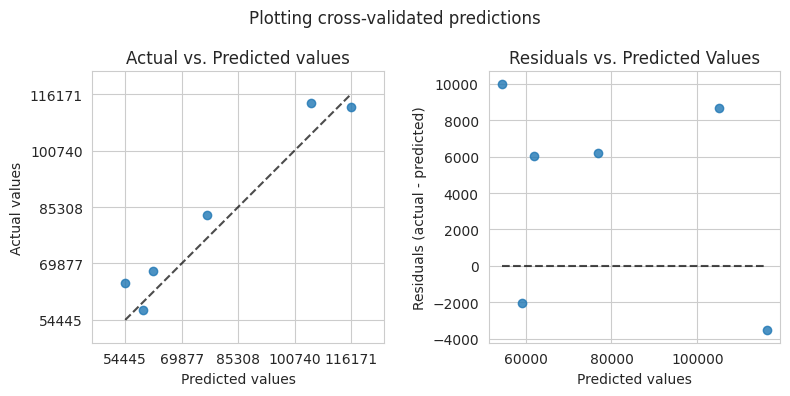

In [19]:
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y.Salary,
    y_pred=y.Salary_pred,
    kind="actual_vs_predicted",
    subsample=None,
    ax=axs[0],
    random_state=42,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y.Salary,
    y_pred=y.Salary_pred,
    kind="residual_vs_predicted",
    subsample=None,
    ax=axs[1],
    random_state=42,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

In [21]:
mean_rel_error = []

for k in k_values:

    pipe = make_pipeline(StandardScaler(),
                         PCA(n_components=2),
                         KNeighborsRegressor(n_neighbors=k, n_jobs=-1, weights='distance'),
                         )


    pipe.fit(X_train, y_train.values.ravel())

    y_pred = pipe.predict(X_test)

    y = y_test.copy()
    y['Salary_pred'] = y_pred
    y['rel_error'] = abs(y.Salary - y.Salary_pred)*100/y.Salary
    mean_rel_error.append(y['rel_error'].mean())

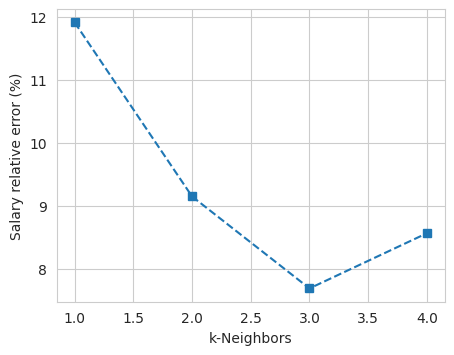

In [22]:
plt.figure(figsize=(5, 3.8))

plt.plot(k_values, mean_rel_error, marker='s', linestyle='--')

plt.ylabel("Salary relative error (%)")
plt.xlabel("k-Neighbors")

plt.show()